# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Name & PID

- Name: Alexander Vo
- PID: A15049294

# Research Question

What factors can improve restaurant health violation penalty consistency? How accurate will penalty score classification be based upon inspector comments? Will adding a "social perception" dimension through Yelp data improve classification?

## Background and Prior Work

According to County of San Diego Department of Environmental Health [4], restaurant are given a score out of a 100 upon inspection. Violations incur a penalty from 2-4 (no violations incur a penalty of 1), and a letter grade is assigned: "A" for 90-100, "B" for 80-89, and "C" 0 to 79. "C" is considered a failing grade. The exact score is usually not displayed, only the letter grade [3]. Re-inspections can be requested at any time. According to Ho [1] however, San Diego may be inflating scores due to a variety of reasons such as inspector discretion and loose guidelines. These make the scores less trustworthy to the consumer resulting in them being ignored. Due to the variability between inspectors, either stricter guidelines must be implemented or additional tools (such as ML models) must be available to provide constisten heatlh violation score penalties.

Shashank and Balakrishna [2] introduced a possible social dimension of health inspections by scanning Yelp reviews to determine random health inspection locations. They found some correltations between health code adherence and review sentiment such as overwhelming negative words in a dirty restaurant and talking more about a restaurant's atmosphere in a clean restaurant.

References:
- 1) Daniel E. Ho, *Fudging the Nudge: Information Disclosure and Restaurant Grading*, 122 Yale L. J. 574 (2012). https://heinonline.org/HOL/Page?handle=hein.journals/ylr122&collection=journals&id=605&startid=&endid=720
- 2) Uppoor, Shashank, and Shreyas Pathre Balakrishna. *Predicting Restaurant Health Inspection Penalty Score from Yelp Reviews*. University of California, San Diego, jmcauley.ucsd.edu/cse258/projects/fa15/036.pdf.
- 3) Filion, Katie, and Douglas A. Powell. *The Use of Restaurant Inspection Disclosure Systems as a Means of Communicating Food Safety Information* Journal of Foodservice, vol. 20, no. 6, 2009, pp. 287–297., doi:10.1111/j.1748-0159.2009.00151.x.
- 4) “SD Food Info.” SD Food Info Start Search, www.sandiegocounty.gov/content/sdc/deh/fhd/ffis/intro.html.html.

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

- Dataset Name: restaurants.csv
- Link: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 3324 rows, 14 columns

Holds basic data for food-serving venues (not just restaurants) such as location, phone number, and zip code. One restaurant per row.

- Dataset Name: violations.csv
- Link: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 189802 rows, 18 columns

Lists a health safety violation per row and containts related data such as inspector, date, and point penalty.

- Dataset Name: yelp.csv
- Link: https://canvas.ucsd.edu/courses/12630/assignments/110486
- Number of observations: 3688 rows, 31 columns

Lists one venue per row (with potential duplicates) and contains consumer data such as rating, reviewer count, and address.


Restaurants and health violations can be linked together by a common "hsisid" (renamed to "id") value (each id is unique per restaurant). Yelp data will be connected to restaurant and health violations via zip code and name.

# Setup

In [312]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import random

import seaborn as sns

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler

# Data Cleaning

1) Load all datasets without any alteration
  * restaurant_df = restaurant.csv
  * violations_df = violations.csv
  * yelp_df = yelp.csv
   
2) Drop unnecessary/ambiguous/PII columns from all datasets such as:
  * restaurant_df: phonenumber
  * violations_df: X.objectid
  * yelp_df: phone
  
3) Minor column renamings such as:
  * "hsisid" => "id"
  
4) Run standardization converters on select columns (restaurant names, zipcode)

5) Remove any duplicate entries

6) Filter food-servicing locations to only include restaurants

7) Merge restaurant health data with Yelp data based on name and zipcode

8) Remove restaurant health data with no Yelp Data

9) Anonymize restaurant data

#### Converters / Standardizers

Remove punctuation. Standardize names if from a big chain.

In [19]:
def convert_restaurant_names(name_in):
        
    # Make the input all lowercase
    name_in = name_in.lower()
    
    # Drop all whitespace
    name_in = name_in.strip()
    
    # Chain restaurants have are of format 'chain name #NUMBER'
    # Remove '#NUMBER' is present
    hash_index = name_in.find('#')
    if hash_index != -1:
        name_in = name_in[0:hash_index]
        
    name_in = name_in.replace("i pre-security", "")
    name_in = name_in.replace("&amp;", "and")
    name_in = name_in.replace("&", "and")
        
    if "subway" in name_in:
        name_in = "subway"
    elif "mcdonald's" in name_in or "mcdonalds" in name_in:
        name_in = "mcdonald's"
    elif "starbuck" in name_in:
        name_in = "starbuck"
    elif "dunkin donuts" in name_in:
        name_in = "dunkin donuts"
    elif "arby's" in name_in:
        name_in = "arby's"
    elif "jersey mike" in name_in:
        name_in = "jersey mike"
    elif "wendy's" in name_in:
        name_in = "wendy's"
    elif "jamba j" in name_in:
        name_in = "jamba juice"
    elif "culver" in name_in:
        name_in = "culver's"
    elif "einstein" in name_in and "bagel" in name_in:
        name_in = "einstein bros bagel"
    elif "whataburger" in name_in:
        name_in = "whataburger"
    elif "church's chicken" in name_in:
        name_in = "church's hicken"
    elif "five guys" in name_in:
        name_in = "five guys"
    elif "chick-fil-a" in name_in:
        name_in = "chick-fil-a"
    elif "aubrey" in name_in and "peedi" in name_in and "grill" in name_in:
        name_in = "aubrey and peedies grill"
    elif "skipper's fish fry" in name_in or "skipper`s fish fry and market" == name_in:
        name_in = "skipper's fish fry"
    elif "dean's seafood grill" in name_in:
        name_in = "dean's seafood grill and bar"
    elif "salvio" in name_in and "pizzeria" in name_in:
        name_in = "salvio's pizzeria"
    elif "manchester" in name_in and "grill" in name_in:
        name_in = "manchester bar and grill"
    elif "sam" in name_in and "club" in name_in:
        name_in = "sam's club"
    elif "sami" in name_in and "pizza" in name_in and "more" in name_in:
        name_in = "sami's subs, pizza, and more"
        
    if name_in == "spring cafe 2":
        name_in = "spring cafe"
    
    return name_in.strip()

assert convert_restaurant_names("chick-fil-a #1573") == 'chick-fil-a'
assert convert_restaurant_names("taco bell #22798") == 'taco bell'
assert convert_restaurant_names("chick-fil-a of knightdale") == "chick-fil-a"

In [20]:
def convert_time(str_in):
    return pd.to_datetime(str_in)

Converts ZIP codes of form "AAAAA-BBBB" to form "AAAAA". "AAAAA-BBBB" are specific version of "AAAAA"

In [21]:
def convert_zip(zipcode):
    
    # ZIP codes of form "AAAAA-BBBB" are specific version of "AAAAA"
    hyphen_index = zipcode.find('-')
    if hyphen_index != -1:
        zipcode = zipcode[0:hyphen_index]

    zipcode = zipcode.strip()
    return zipcode


assert convert_zip("12345") == "12345"
assert convert_zip("12345-678") == "12345"

Comments tend to have extra metadata in the front separated by a semicolons or a dash. Such metadata can already be found in the columns dropped during cleanup so can also be removed.

In [376]:
def convert_comments(data_in):
    if pd.isna(data_in):
        return data_in;
    
    semi_index = data_in.find(';')
    if semi_index != -1:
        data_in = data_in[semi_index + 1:]
    
    dash_index = data_in.find('-')
    if dash_index != -1:
        data_in = data_in[dash_index + 1:]
        
    semi_index = data_in.find(';')
    if semi_index != -1:
        data_in = data_in[semi_index + 1:]
    
        
    return data_in

### Read Data Unaltered

In [377]:
restaurants_filepath = "restaurants.csv"
restaurants_df = pd.read_csv(restaurants_filepath, dtype={
    "hsisid": str,
    "postal_code": str,
})

violations_filepath = "violations.csv"
violations_df = pd.read_csv(violations_filepath, dtype={
    "hsisid": str,
    "comments": str,
})

yelp_filepath = "yelp.csv"
yelp_df = pd.read_csv(yelp_filepath, dtype={
    "zip_code": str
})

Clean up restaurant data (converters, drop columns, renaming, deduplicate)

In [378]:
restaurants_df_clean = restaurants_df.drop(labels=[
    "X.objectid",
    "name",
    "state",
    "address1",
    "address2",
    "city",
    "phonenumber",
    "geocodestatus",
    "x",
    "y",
    "facilitytype",
    "restaurantopendate"
], axis="columns")

restaurants_df_clean.rename(columns={
    "hsisid": "id",
    "postalcode": 'zip',
    #"restaurantopendate": "open_date"
}, inplace=True)

restaurants_df_clean = restaurants_df_clean[(restaurants_df["facilitytype"] == "Restaurant") 
                                            & (restaurants_df["facilitytype"] == "Restaurant")]
restaurants_df_clean["name"] = restaurants_df["name"].apply(convert_restaurant_names)
restaurants_df_clean["zip"] = restaurants_df_clean["zip"].apply(convert_zip)
#restaurants_df_clean["open_date"] = restaurants_df_clean["open_date"].apply(convert_time)

restaurant_ids = restaurants_df_clean["id"]

restaurants_df_clean = restaurants_df_clean.reindex()
assert restaurants_df_clean["id"].is_unique == True

Clean up health violation data (converters, drop columns, renaming, deduplicate)

In [379]:
violations_df_clean = violations_df.drop(labels=[
    "X.objectid",
    "statecode",
    "questionno",
    "violationcode",
    "inspectedby",
    "cdcriskfactor",
    "cdcdataitem",
    "violationtype",
    "observationtype",
    "count",
    "category",
    "shortdesc",
    "severity",
    "critical",
    "inspectdate"
], axis="columns")
    
violations_df_clean.rename(columns={
    "hsisid": "id",
    "pointvalue": "penalty",
}, inplace=True)

# violations_df_clean["inspect_date"] = violations_df_clean["inspect_date"].apply(convert_time)
violations_df_clean.drop_duplicates(inplace=True)
violations_df_clean["comments"] = violations_df_clean["comments"].apply(convert_comments)
violations_df_clean = violations_df_clean.reindex()

Clean up Yelp data (converters, drop columns, renaming, deduplicate)

In [380]:
yelp_df_clean = yelp_df.drop(labels=[
    "address1",
    "name",
    "price",
    "italian",
    "seafood",
    "newamerican",
    "chicken_wings",
    "delis",
    "bars",
    "salad",
    "seafood",
    "bbq",
    "bakeries",
    "sushi",
    "phone",
    "hotdogs",
    "sandwiches",
    "pizza",
    "tradamerican",
    "burgers",
    "mexican",
    "grocery",
    "breakfast_brunch",
    "coffee",
    "chinese",
    "latitude",
    "longitude",
    "price",
    "id",
    "is_closed",
], axis="columns")


yelp_df_clean.rename(columns={
    "id": "yelp_id",
    "zip_code": 'zip'
}, inplace=True)

yelp_df_clean["name"] = yelp_df["name"].apply(convert_restaurant_names)
yelp_df_clean["zip"] = yelp_df_clean["zip"].apply(convert_zip)

yelp_df_clean = yelp_df_clean[["zip", "name", "rating", "review_count"]]

In [381]:
restaurants_df_clean.head()

,id,zip,name
0,4092017230,27616,spring cafe
2,4092014444,27587,taco bell
3,4092015333,27601,the remedy diner
6,4092016679,27601,bittersweet
7,4092014493,27617,chick-fil-a


In [382]:
violations_df_clean.head()

,id,comments,penalty
0,4092015279,Found unlabeled bottle with purple liquid in ...,0
1,4092014572,Sanitizer bottle was labeled.,0
2,4092015906,Found an unlabeled spray bottle and large jug...,1
3,4092013840,Found unlabeled bottle with purple liquid in ...,0
4,4092021788,Found one unlabeled bottle of degreaser. Prop...,0


In [383]:
yelp_df_clean.head()

,zip,name,rating,review_count
0,27560,42nd street oyster bar - rdu airport,2.5,23
1,27519,aldi foods,4.0,17
2,27612,luciano pizzeria ristorante,5.0,2
3,27893,olive garden italian restaurant,3.0,16
4,27896,subway,3.5,3


### Connect Restaurant "id" to Yelp Data

Merge based on restaurant name (standardized) and zipcode (standardized)

In [384]:
merged_df = restaurants_df_clean.merge(yelp_df_clean, how="left", left_on=["zip", "name"], right_on=["zip", "name"])
merged_df.dropna(axis="index", how="any", subset=["rating"], inplace=True)

merged_df = merged_df[["id", "zip", "name", "rating", "review_count"]]

In [385]:
merged_df.head()

,id,zip,name,rating,review_count
0,4092017230,27616,spring cafe,3.5,35.0
1,4092014444,27587,taco bell,3.0,8.0
2,4092015333,27601,the remedy diner,4.0,347.0
3,4092016679,27601,bittersweet,4.0,150.0
4,4092014493,27617,chick-fil-a,3.5,20.0


In [386]:
# Rows with duplicate "id"
conflicting = merged_df[merged_df.duplicated(subset=["id"], keep=False)]
conflicting.head()

,id,zip,name,rating,review_count
16,4092014233,27526,sheetz,2.0,3.0
17,4092014233,27526,sheetz,4.0,1.0
18,4092014233,27526,sheetz,4.5,8.0
32,4092016069,27502,subway,4.0,2.0
33,4092016069,27502,subway,2.0,3.0


Here, rows with conflicting "id" entries are dropped. Duplicate "id" entries are caused by conflicting Yelp data (multiple ratings/review counts per location). It has already been previously verified that "id" values are unique to each restaurant. There is no satisfactory resolution to this conflict.

In [387]:
final_restaurant_df = merged_df.drop_duplicates(subset="id")

Drop any PII

In [388]:
final_restaurant_df = final_restaurant_df.drop(labels=[
    "zip",
    "name",
], axis="columns")

### Data Ready for Analysis

In [389]:
final_restaurant_df.head()

,id,rating,review_count
0,4092017230,3.5,35.0
1,4092014444,3.0,8.0
2,4092015333,4.0,347.0
3,4092016679,4.0,150.0
4,4092014493,3.5,20.0


In [390]:
violations_df_clean.head()

,id,comments,penalty
0,4092015279,Found unlabeled bottle with purple liquid in ...,0
1,4092014572,Sanitizer bottle was labeled.,0
2,4092015906,Found an unlabeled spray bottle and large jug...,1
3,4092013840,Found unlabeled bottle with purple liquid in ...,0
4,4092021788,Found one unlabeled bottle of degreaser. Prop...,0


# Data Analysis & Results

Notes:
* Penalty score and rating are being treated as categorical data

Associate the Restaurant's Yelp Data with each Health Violation

In [391]:
violation_full_df = violations_df_clean.merge(final_restaurant_df, how="right", on="id")

# Remove entries without any comments
violation_full_df.dropna(how="any", subset=["comments", "rating", "review_count"], inplace=True)

In [392]:
violation_full_df.head()

,id,comments,penalty,rating,review_count
0,4092010287,Found unlabeled bottle with blue liquid insid...,0.0,4.5,193.0
1,4092010287,based food and has insufficient consumer advis...,0.0,4.5,193.0
2,4092010287,"603.11- Establishment found to offer meat, sea...",0.0,4.5,193.0
3,4092010287,103.11(M)- Establishment found to lack an empl...,0.0,4.5,193.0
4,4092010287,Found some unlabeled bottles/containers of co...,0.0,4.5,193.0


## EDA

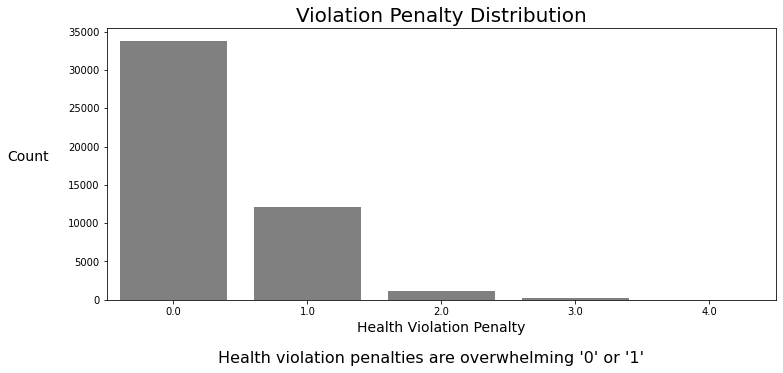

In [393]:
penalty_plot = sns.countplot(x="penalty", data=violation_full_df, color="grey", orient="v")
penalty_plot.set_xlabel("Health Violation Penalty", fontsize=14)
penalty_plot.set_ylabel("Count", rotation=0,labelpad=40, fontsize=14)
penalty_plot.set_title("Violation Penalty Distribution", fontsize=20)
penalty_plot.set_xticks([0, 1, 2, 3 ,4], minor=False);

caption = "Health violation penalties are overwhelming '0' or '1'"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=16);

penalty_plot = plt.gcf()
penalty_plot.set_size_inches(12, 5, forward=True)

In [394]:
violation_full_df.shape

(47364, 5)

This should not come as a surprise. If restaurants had multiple violations with penalties of 2 or more, they would have poorer total scores and would be more likely to close due to health code violations. However, the sheer number of 0 cost penalties is staggering which again begs the question: how lenient are inspectors being? Penalties of 2 or more points are demonstrated to be extremely rare (1480/47364 or 3.125%).

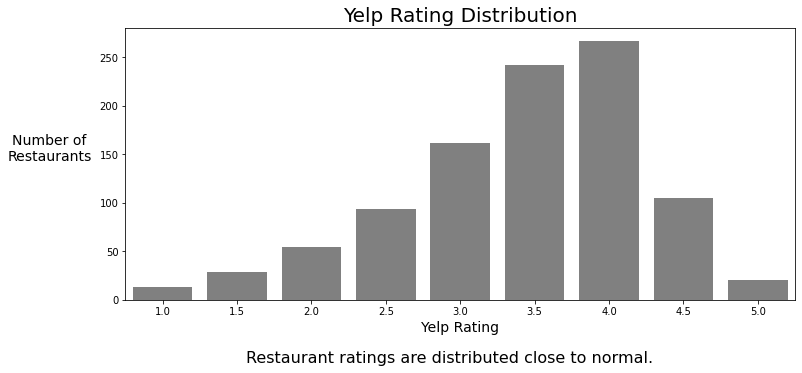

In [395]:
yelp_review_plot = sns.countplot(final_restaurant_df["rating"], color="grey")
yelp_review_plot.set_xlabel("Yelp Rating", fontsize=14)
yelp_review_plot.set_ylabel("Number of\nRestaurants", rotation=0, labelpad=50, fontsize=14)
yelp_review_plot.set_title("Yelp Rating Distribution", fontsize=20)

caption = "Restaurant ratings are distributed close to normal."
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=16);

penalty_plot = plt.gcf()
penalty_plot.set_size_inches(12, 5, forward=True)

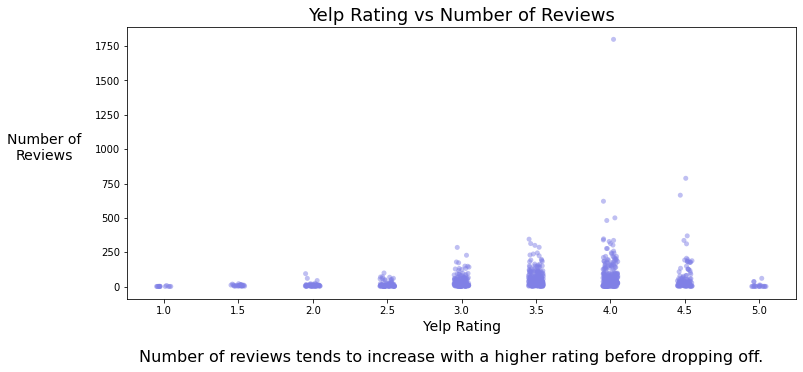

In [396]:
rating_review_count_plot = sns.stripplot(x="rating", y="review_count", data=final_restaurant_df, color=[0.5, 0.5, 0.9], linewidth=0, alpha=0.5)
rating_review_count_plot.set_xlabel("Yelp Rating", fontsize=14)
rating_review_count_plot.set_ylabel("Number of\nReviews", rotation=0,labelpad=50, fontsize=14)
rating_review_count_plot.set_title("Yelp Rating vs Number of Reviews", fontsize=18)

caption = "Number of reviews tends to increase with a higher rating before dropping off."
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=16);

penalty_plot = plt.gcf()
penalty_plot.set_size_inches(12, 5, forward=True)

There is one outlier with rating of four with a number of reviews of around 1800. In general however, there is a visible trend of higher number of reviews for higher rated restaurants which begins to drop off after a rating of 4.

Average comment lenght: 196.74660079385188


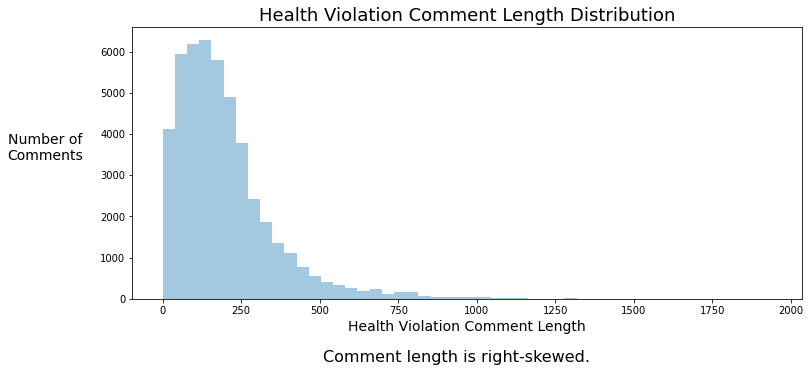

In [397]:
comment_length_plot = sns.distplot(violation_full_df["comments"].apply(lambda c: len(c)), kde=False)
comment_length_plot.set_xlabel("Comment Length")

print("Average comment lenght: {}".format(violation_full_df["comments"].apply(lambda c: len(c)).agg("mean")))

comment_length_plot.set_xlabel("Health Violation Comment Length", fontsize=14)
comment_length_plot.set_ylabel("Number of\nComments", rotation=0,labelpad=55, fontsize=14)
comment_length_plot.set_title("Health Violation Comment Length Distribution", fontsize=18)

caption = "Comment length is right-skewed."
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=16);

comment_length_plot = plt.gcf()
comment_length_plot.set_size_inches(12, 5, forward=True)

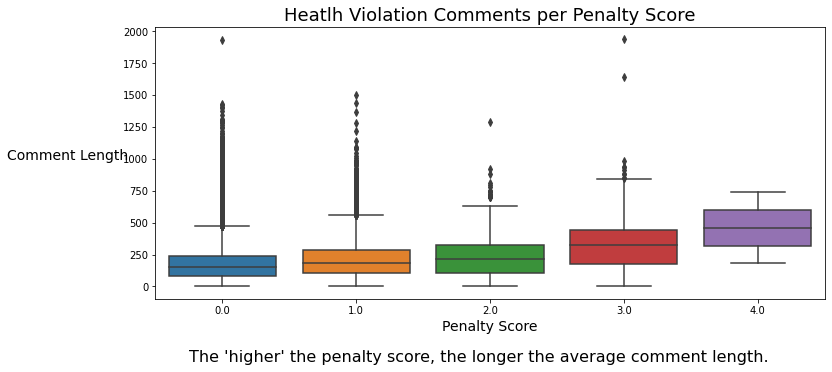

In [398]:
penalty_comment_length_plot = sns.boxplot(x=violation_full_df["penalty"], y=violation_full_df["comments"].apply(lambda c: len(c)))

penalty_comment_length_plot.set_xlabel("Penalty Score", fontsize=14)
penalty_comment_length_plot.set_ylabel("Comment Length", rotation=0,labelpad=55, fontsize=14)
penalty_comment_length_plot.set_title("Heatlh Violation Comments per Penalty Score", fontsize=18)

caption = "The \'higher\' the penalty score, the longer the average comment length."
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=16);

penalty_comment_length_plot = plt.gcf()
penalty_comment_length_plot.set_size_inches(12, 5, forward=True)

The higher the penalty, the more severe the health code violation. Thus, it would make more sense that the average comment length would increase. However, the sheer number of outliers for a penalty score of 0 brings into question what inspectors are actually commenting about. If it were a minor infraction, it would be reasonable to think that there would be less to discuss.

## Model Generation

In [399]:
# Randomize input data
violation_full_df = violation_full_df.sample(frac=1, random_state=200).reset_index(drop=True)
violation_full_df.head()

,id,comments,penalty,rating,review_count
0,4092013869,Remove rusty wire shelves in seafood refriger...,1.0,3.5,230.0
1,4092015210,The floor grout in the high traffic areas is ...,1.0,3.0,19.0
2,4092016427,601.11 (A) . The ice machine is starting to ha...,0.0,3.5,82.0
3,4092011286,Store wet wiping cloths in sanitizer. Observ...,0.0,3.5,46.0
4,4092015923,Due to the new installation of the hood syste...,0.0,4.5,311.0


In [400]:
# Generic SVM training routine
def train_SVM(X, Y, kernel='linear', class_weight=None):
    model = SVC(kernel=kernel, class_weight=class_weight)
    model.fit(X, Y)
    return model

Calculate number of observations

In [401]:
# performance_scale is used to take a subset of the data in order to train the models in a reasonable time
performance_scale = 0.3
num_total = int(violation_full_df.shape[0] * performance_scale)
num_training = int(0.8 * num_total)
num_test = int(0.2 * num_total)

print("Training:\t{}\nTesting:\t{}\nTOTAL:\t\t{}".format(num_training, num_test,num_total))

Training:	11367
Testing:	2841
TOTAL:		14209


#### Classification Based on Yelp Rating

In [402]:
# Translate rating into a value between [0, 1]
min_max_scaler = MinMaxScaler()
rating_X = np.array(violation_full_df["rating"]).reshape(-1, 1)
rating_X = min_max_scaler.fit_transform(rating_X)

In [403]:
rating_Y = np.array(violation_full_df['penalty'])

In [404]:
rating_train_x = rating_X[0:num_training]
rating_test_x = rating_X[num_training:num_training+num_test]

rating_train_y = rating_Y[0:num_training]
rating_test_y = rating_Y[num_training:num_training+num_test]

In [405]:
svm_model_pure_rating = train_SVM(rating_train_x, rating_train_y,kernel='rbf')

In [406]:
df_predicted_raiting_train_y = svm_model_pure_rating.predict(rating_train_x)

In [441]:
print("Training data performance")
rating_train_report = classification_report(rating_train_y, df_predicted_raiting_train_y, zero_division=0, output_dict=True)
print(classification_report(rating_train_y, df_predicted_raiting_train_y, zero_division=0))

Training data performance
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83      8078
         1.0       0.00      0.00      0.00      2945
         2.0       0.00      0.00      0.00       282
         3.0       0.00      0.00      0.00        61
         4.0       0.00      0.00      0.00         1

    accuracy                           0.71     11367
   macro avg       0.14      0.20      0.17     11367
weighted avg       0.51      0.71      0.59     11367



In [442]:
df_predicted_rating_test_y = svm_model_pure_rating.predict(rating_test_x)

In [443]:
print("Test data performance")
rating_test_report = classification_report(rating_test_y, df_predicted_rating_test_y, zero_division=0, output_dict=True)
print(classification_report(rating_test_y, df_predicted_rating_test_y, zero_division=0))

Test data performance
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.83      1997
         1.0       0.00      0.00      0.00       750
         2.0       0.00      0.00      0.00        79
         3.0       0.00      0.00      0.00        15

    accuracy                           0.70      2841
   macro avg       0.18      0.25      0.21      2841
weighted avg       0.49      0.70      0.58      2841



#### Classification Based on Comment Content

In [444]:
# Create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, #apply sublinear TF scaling
                        analyzer='word',   #specify tokenizer
                        max_features=50, # specify max # of features to include
                        tokenizer=word_tokenize,
                        stop_words="english")

# Learn vocabulary and idf, return term-document matrix.
# return an array;our predictor
tfidf_X = tfidf.fit_transform(violation_full_df['comments']).toarray()

In [445]:
tfidf_Y = np.array(violation_full_df['penalty'])

Partition the data into training/test sets

In [446]:
tfidf_train_x = tfidf_X[0:num_training]
tfidf_test_x = tfidf_X[num_training:num_training+num_test]

tfidf_train_y = tfidf_Y[0:num_training]
tfidf_test_y = tfidf_Y[num_training:num_training+num_test]

In [447]:
svm_model_pure_tfidf = train_SVM(tfidf_train_x, tfidf_train_y, kernel='rbf')

In [448]:
df_predicted_tfidf_train_y = svm_model_pure_tfidf.predict(tfidf_train_x)

In [449]:
print("Training data performance")
comment_train_report = classification_report(tfidf_train_y, df_predicted_tfidf_train_y, zero_division=0, output_dict=True)
print(classification_report(tfidf_train_y, df_predicted_tfidf_train_y, zero_division=0))

Training data performance
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86      8078
         1.0       0.80      0.27      0.40      2945
         2.0       0.82      0.36      0.50       282
         3.0       0.00      0.00      0.00        61
         4.0       0.00      0.00      0.00         1

    accuracy                           0.77     11367
   macro avg       0.48      0.32      0.35     11367
weighted avg       0.78      0.77      0.73     11367



In [450]:
df_predicted_tfidf_test_y = svm_model_pure_tfidf.predict(tfidf_test_x)

In [451]:
print("Testing data performance")
comment_test_report = classification_report(tfidf_test_y, df_predicted_tfidf_test_y, zero_division=0, output_dict=True)
print(classification_report(tfidf_test_y, df_predicted_tfidf_test_y, zero_division=0))

Testing data performance
              precision    recall  f1-score   support

         0.0       0.74      0.96      0.84      1997
         1.0       0.64      0.18      0.28       750
         2.0       0.66      0.27      0.38        79
         3.0       0.00      0.00      0.00        15

    accuracy                           0.73      2841
   macro avg       0.51      0.35      0.37      2841
weighted avg       0.71      0.73      0.67      2841



#### Classification Based on Yelp Rating and Comment Content

In [452]:
comment_rating_X = np.concatenate((tfidf_X, rating_X), axis=1)

In [453]:
comment_rating_Y = np.array(violation_full_df['penalty'])

In [454]:
comment_rating_train_x = comment_rating_X[0:num_training]
comment_rating_test_x = comment_rating_X[num_training:num_training+num_test]

comment_rating_train_y = comment_rating_Y[0:num_training]
comment_rating_test_y = comment_rating_Y[num_training:num_training+num_test]

In [455]:
svm_model_comment_rating = train_SVM(comment_rating_train_x, comment_rating_train_y, kernel='rbf')

In [456]:
df_predicted_comment_rating_train_y = svm_model_comment_rating.predict(comment_rating_train_x)

In [457]:
print("Training data performance")
comment_rating_train_report = classification_report(comment_rating_train_y, df_predicted_comment_rating_train_y, zero_division=0, output_dict=True)
print(classification_report(comment_rating_train_y, df_predicted_comment_rating_train_y, zero_division=0))

Training data performance
              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85      8078
         1.0       0.80      0.19      0.31      2945
         2.0       0.83      0.29      0.43       282
         3.0       0.00      0.00      0.00        61
         4.0       0.00      0.00      0.00         1

    accuracy                           0.76     11367
   macro avg       0.47      0.29      0.32     11367
weighted avg       0.76      0.76      0.70     11367



In [458]:
df_predicted_comment_rating_test_y = svm_model_comment_rating.predict(comment_rating_test_x)

In [459]:
print("Testing data performance")
comment_rating_test_report = classification_report(comment_rating_test_y, df_predicted_comment_rating_test_y, zero_division=0, output_dict=True)
print(classification_report(comment_rating_test_y, df_predicted_comment_rating_test_y, zero_division=0))

Testing data performance
              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83      1997
         1.0       0.68      0.14      0.24       750
         2.0       0.65      0.22      0.32        79
         3.0       0.00      0.00      0.00        15

    accuracy                           0.73      2841
   macro avg       0.52      0.33      0.35      2841
weighted avg       0.71      0.73      0.66      2841



In [494]:
performance_df = pd.DataFrame([
    ["Rating", rating_train_report["accuracy"], "Train"],
    ["Rating", rating_test_report["accuracy"], "Test"],
    ["Comment", comment_train_report["accuracy"], "Train"],
    ["Comment", comment_test_report["accuracy"], "Test"],
    ["Comment-Rating", comment_rating_train_report["accuracy"], "Train"],
    ["Comment-Rating", comment_rating_test_report["accuracy"], "Test"],
], columns=["Model", "Data Accuracy", "Kind"])

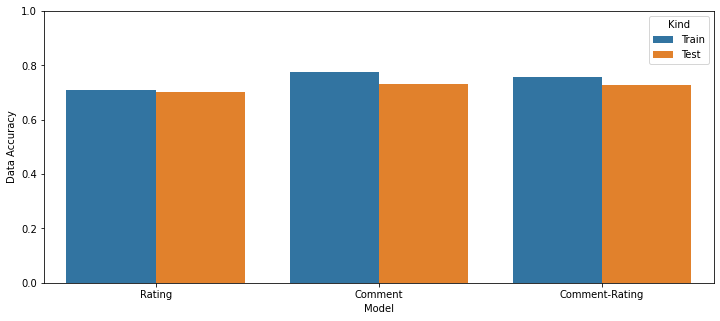

In [496]:
accuracy_plot = sns.barplot(x="Model", y="Data Accuracy", hue="Kind", data=performance_df)
accuracy_plot.set(ylim=(0, 1))

penalty_plot = plt.gcf()
penalty_plot.set_size_inches(12, 5, forward=True)

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*